# AusWave Data Download and Processing

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = Path(os.getcwd()).parents[0]
sys.path.append(str(path_root))
sys.path.append(str(Path(os.getcwd()).parents[1]))

%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import deepcopy
import numpy as np

In [91]:
import netCDF4 as nc
from cftime import num2date, date2num
from datetime import datetime

In [4]:
import jax
import jax.numpy as jnp
from jax import vmap, jit
# from tensorflow_probability.substrates.jax import distributions as tfd
# import optax
# import equinox as eqx
from jax.lib import xla_bridge

In [5]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


## Read Data

In [261]:
ocean1 = nc.Dataset('IDY35100.G3.pop-flds.slv.2022031512.000.surface.nc4')
ocean2 = nc.Dataset('IDY35100.G3.pop-flds.slv.2022031512.024.surface.nc4')

wave_vars = [
    'merid_wnd', 'mn_dir_sw1', 'mn_dir_sw2', 'mn_dir_sw3', 'mn_dir_wnd_sea',
    'mn_wav_dir', 'mn_wav_per', 'pk_per_sw1', 'pk_per_sw2', 'pk_per_sw3', 
    'pk_per_wnd_sea', 'pk_wav_dir', 'pk_wav_per', 'sig_ht_sw1', 
    'sig_ht_sw2', 'sig_ht_sw3', 'sig_ht_wnd_sea', 'sig_wav_ht', 't02', 
    'tm01', 'wav_engy_flux', 'wnd_dir', 'wnd_spd', 'zonal_wnd'
]

var_names = {k: v.long_name for k, v in ocean1.variables.items()}

In [263]:
def process_netcdf(dataset):
    # date and time
    t = dataset.variables['time']
    t = num2date(
        dataset.variables['time'][:], dataset.variables['time'].units
    )[0]
    t = datetime(t.year, t.month, t.day, t.hour, t.minute, t.second)
    t = pd.to_datetime(t)
    print(t)

    # lat lon mesh grid
    lat = np.array(dataset.variables['lat'][:])
    lon = np.array(dataset.variables['lon'][:])
    lon, lat = np.meshgrid(lon, lat)
    coords = np.stack([lat, lon], axis=-1)

    # atmospheric vars
    vars_processed = []
    for var in wave_vars:
        var_data = dataset.variables[var]
        missing_val = var_data.missing_value
        var_arr = np.array(var_data[:])[0]
        var_arr[var_arr == missing_val] = np.nan
        vars_processed.append(var_arr)

    vars_processed = np.stack(vars_processed, axis=-1)
    data = np.concatenate([coords, vars_processed], axis=-1)

    # create pd dataframe
    data_dict = {}
    for i, var in enumerate(wave_vars):
        data_dict[var] = data[:, :, i+2].flatten()
    data_dict['lat'] = data[:, :, 0].flatten()
    data_dict['lon'] = data[:, :, 1].flatten()
    df = pd.DataFrame(data_dict)

    return data, df

In [264]:
data1, df1 = process_netcdf(ocean1)
land_mask1 = np.isnan(data1[..., 2:]).all(axis=-1)

2022-03-15 12:00:00


In [265]:
data2, df2 = process_netcdf(ocean2)
land_mask2 = np.isnan(data2[..., 2:]).all(axis=-1)

2022-03-16 12:00:00


## EDA

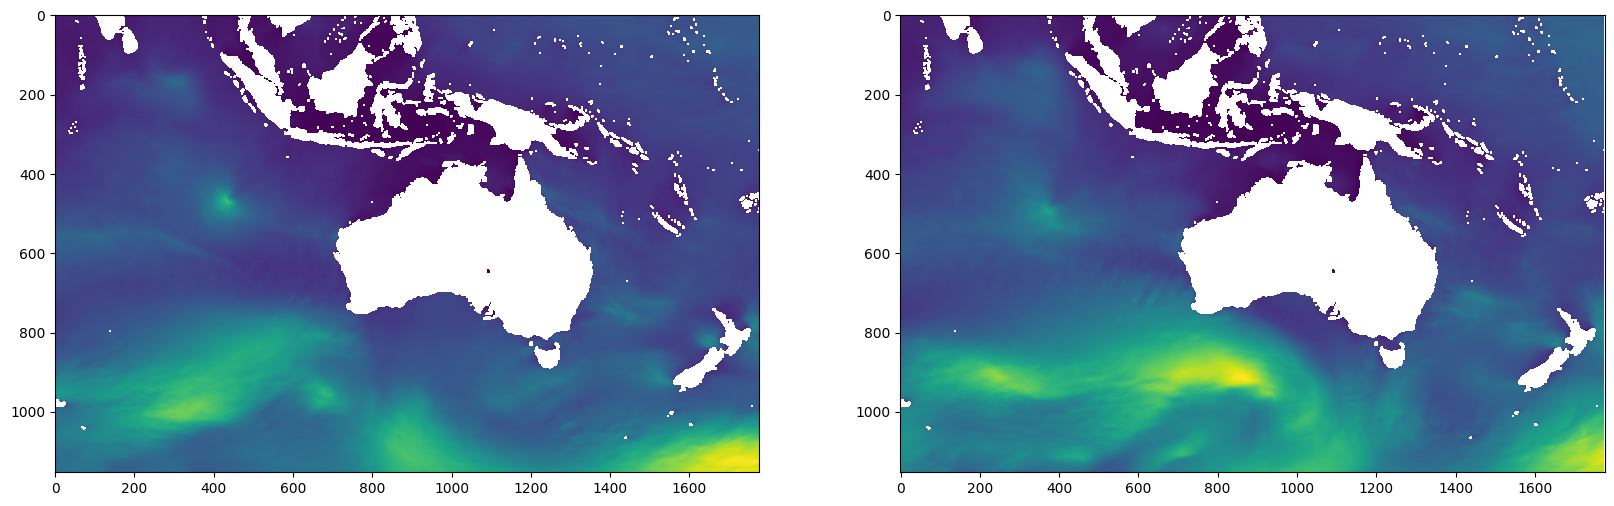

In [251]:
ind = wave_vars.index('sig_wav_ht')

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(data1[..., ind + 2], cmap='viridis')
ax[1].imshow(data2[..., ind + 2], cmap='viridis')
plt.show()


In [280]:
corrs = df1[wave_vars].corr()['sig_wav_ht'].sort_values(ascending=False)
for var in corrs.index.tolist():
    print(f'{corrs[var]:.2f} -- {var} -- {var_names[var]}')

1.00 -- sig_wav_ht -- Significant Wave Height
0.97 -- sig_ht_wnd_sea -- Significant height of wind sea
0.91 -- wav_engy_flux -- Wave energy flux
0.84 -- wnd_spd -- Wind Speed
0.79 -- pk_per_wnd_sea -- Peak Period of wind sea
0.66 -- t02 -- Mean zero crossing wave period
0.59 -- mn_wav_per -- Mean Wave Period
0.56 -- sig_ht_sw1 -- Significant height of primary swell
0.48 -- zonal_wnd -- U component of wind
0.44 -- tm01 -- Inverse of mean frequency
0.41 -- pk_per_sw1 -- Peak Period of primary swell
0.41 -- mn_wav_dir -- Mean Wave Direction
0.39 -- mn_dir_wnd_sea -- Mean Direction of wind sea
0.38 -- pk_wav_dir -- Peak Wave Direction
0.35 -- sig_ht_sw2 -- Significant height of secondary swell
0.33 -- pk_per_sw3 -- Peak Period of tertiary swell
0.27 -- wnd_dir -- Wind Direction
0.24 -- mn_dir_sw1 -- Mean Direction of primary swell
0.20 -- pk_per_sw2 -- Peak Period of secondary swell
0.18 -- pk_wav_per -- Peak Wave Period
0.17 -- sig_ht_sw3 -- Significant height of tertiary swell
-0.01 -- m

In [273]:
missing_pct = (df1.isna().sum(axis=0) / df1.shape[0]).sort_values(ascending=True)
for var in missing_pct.index.tolist():
    print(f'{df1[var].isna().sum() / df1.shape[0]:.2f} -- {var} -- {var_names[var]}')

0.00 -- lon -- longitudes
0.00 -- lat -- latitudes
0.13 -- zonal_wnd -- U component of wind
0.13 -- wnd_spd -- Wind Speed
0.13 -- wnd_dir -- Wind Direction
0.13 -- wav_engy_flux -- Wave energy flux
0.13 -- tm01 -- Inverse of mean frequency
0.13 -- t02 -- Mean zero crossing wave period
0.13 -- sig_wav_ht -- Significant Wave Height
0.13 -- merid_wnd -- V component of wind
0.13 -- mn_wav_per -- Mean Wave Period
0.13 -- mn_wav_dir -- Mean Wave Direction
0.13 -- pk_wav_per -- Peak Wave Period
0.13 -- pk_wav_dir -- Peak Wave Direction
0.23 -- sig_ht_sw1 -- Significant height of primary swell
0.23 -- pk_per_sw1 -- Peak Period of primary swell
0.23 -- mn_dir_sw1 -- Mean Direction of primary swell
0.43 -- pk_per_sw2 -- Peak Period of secondary swell
0.43 -- sig_ht_sw2 -- Significant height of secondary swell
0.43 -- mn_dir_sw2 -- Mean Direction of secondary swell
0.48 -- pk_per_wnd_sea -- Peak Period of wind sea
0.48 -- sig_ht_wnd_sea -- Significant height of wind sea
0.48 -- mn_dir_wnd_sea -- 

In [ ]:
for i in range(2, data1.shape[-1]):
    plt.imshow(data1[:, :, i])
    plt.title(f'{wave_vars[i-2]}: {var_names[i-2]}')
    plt.colorbar()
    plt.show()
    print(ocean1.variables[wave_vars[i-2]])

## Subset and Save

In [303]:
keep_vals = [
    'lat', 'lon', 'wnd_spd', 'wnd_dir', 'zonal_wnd', 'merid_wnd',
    'mn_wav_per', 'mn_wav_dir', 'sig_wav_ht'
]
df_subset = df1[keep_vals].dropna()
df_subset.to_csv('ocean.csv', index=False)